# 2. Preprocessing

# 2.1 Import Libraries

In [0]:
from pyspark.sql.functions import lit, col, desc, abs, isnan, to_date, rand, length, count, when, hour, dayofweek, round, explode, lower, udf, mean, stddev, min, max, coalesce, concat_ws, row_number, monotonically_increasing_id, floor, round as spark_round

from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, BucketedRandomProjectionLSH
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.window import Window
from pyspark.sql.types import NumericType
from pyspark.sql.functions import countDistinct

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.impute import KNNImputer
from functools import reduce

import re

In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("Preprocessing").getOrCreate()

# 2.2 Import Df

In [0]:
# Import df_eda
df = spark.read.format("delta").load("/dbfs/FileStore/tables/df_eda")

# Display result
df.limit(10).display()

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2015,1,1,4,NK,597,N528NK,MSP,FLL,115,127,12,14,141,207,220,166,1487,527,40,542,607,25,0,0,null,25,0,0,0,0
2015,1,1,4,NK,168,N629NK,PHX,ORD,125,237,72,9,246,204,175,156,1440,622,10,549,632,43,0,0,null,43,0,0,0,0
2015,1,1,4,HA,17,N389HA,LAS,HNL,145,145,0,16,201,370,385,361,2762,602,8,555,610,15,0,0,null,0,0,15,0,0
2015,1,1,4,B6,1030,N239JB,BQN,MCO,307,304,-3,25,329,173,196,160,1129,509,11,500,520,20,0,0,null,20,0,0,0,0
2015,1,1,4,B6,2134,N307JB,SJU,MCO,400,535,95,9,544,185,175,163,1189,727,3,605,730,85,0,0,null,0,0,85,0,0
2015,1,1,4,B6,2276,N646JB,SJU,BDL,438,550,72,15,605,241,258,237,1666,902,6,739,908,89,0,0,null,17,0,72,0,0
2015,1,1,4,AA,1057,N3ASAA,DFW,MIA,515,703,108,15,718,161,155,133,1121,1031,7,856,1038,102,0,0,null,0,0,0,0,102
2015,1,1,4,US,425,N174US,PDX,PHX,520,620,60,13,633,150,150,132,1009,945,5,850,950,60,0,0,null,0,0,60,0,0
2015,1,1,4,AA,89,N3KVAA,IAH,MIA,520,618,58,19,637,141,137,111,964,928,7,841,935,54,0,0,null,0,0,54,0,0
2015,1,1,4,AA,328,N4XKAA,DEN,DFW,530,623,53,32,655,125,138,96,641,931,10,835,941,66,0,0,null,13,0,53,0,0


In [0]:
df.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

In [0]:
print(f"Total rows: {df.count()}")

Total rows: 1063439


# 2.3 Sampling

In [0]:
df_sampled = df.sample(withReplacement=False, fraction=0.05, seed=42)

In [0]:
print(f"Total rows of the sampled dataset: {df_sampled.count()}")

Total rows of the sampled dataset: 53429


# 2.4 Train-Val-Test Split

In [0]:
# Add a random number per row (used to split)
df_with_rand = df_sampled.withColumn("rand", rand(seed=42))

# Create train_df/val/test thresholds
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15

# Assign split label per class using window
window = Window.partitionBy("MONTH").orderBy("rand")

# Count total rows per MONTH to assign quantiles
df_with_counts = df_with_rand.withColumn("row_number", row_number().over(window)) \
    .withColumn("count_in_month", count("*").over(Window.partitionBy("MONTH")))

# Assign split based on cumulative fractions
df_split = df_with_counts.withColumn(
    "split",
    when(col("row_number") <= col("count_in_month") * train_frac, "train")
     .when(col("row_number") <= col("count_in_month") * (train_frac + val_frac), "val")
     .otherwise("test")
)

# Now split the datasets
train_df = df_split.filter(col("split") == "train").drop("rand", "row_number", "count_in_month", "split")
val_df = df_split.filter(col("split") == "val").drop("rand", "row_number", "count_in_month", "split")
test_df = df_split.filter(col("split") == "test").drop("rand", "row_number", "count_in_month", "split")


In [0]:
train_df = train_df.orderBy("DAY", "MONTH", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "FLIGHT_NUMBER", "TAIL_NUMBER")
val_df = val_df.orderBy("DAY", "MONTH", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "FLIGHT_NUMBER", "TAIL_NUMBER")
test_df = test_df.orderBy("DAY", "MONTH", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "FLIGHT_NUMBER", "TAIL_NUMBER")

window = Window.orderBy("DAY", "MONTH", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "FLIGHT_NUMBER", "TAIL_NUMBER")

train_df = train_df.withColumn("index", row_number().over(window))
val_df = val_df.withColumn("index", row_number().over(window))
test_df = test_df.withColumn("index", row_number().over(window))

cols = train_df.columns
cols = ['index'] + [c for c in cols if c != 'index']
train_df = train_df.select(cols)
val_df = val_df.select(cols)
test_df = test_df.select(cols)

In [0]:
# Count total rows per split
total_train = train_df.count()
total_val = val_df.count()
total_test = test_df.count()

print(f"Total rows in train: {total_train}")
print(f"Total rows in val: {total_val}")
print(f"Total rows in test: {total_test}")

Total rows in train: 37396
Total rows in val: 8013
Total rows in test: 8020


In [0]:
print(train_df.select("index").distinct().count())
print(val_df.select("index").distinct().count())
print(test_df.select("index").distinct().count())

37396
8013
8020


In [0]:
# Function to compute proportions by MONTH
def show_month_proportions(df, total_rows, name):
    proportions = df.groupBy("MONTH") \
        .count() \
        .withColumn("percentage", round((col("count") / total_rows) * 100, 2)) \
        .orderBy("MONTH")
    
    print(f"\n{name} Set - Month Distribution (%):")
    proportions.show(truncate=False)

show_month_proportions(train_df, total_train, "Train")
show_month_proportions(val_df, total_val, "Validation")
show_month_proportions(test_df, total_test, "Test")


Train Set - Month Distribution (%):
+-----+-----+----------+
|MONTH|count|percentage|
+-----+-----+----------+
|1    |3394 |9.08      |
|2    |3252 |8.7       |
|3    |3379 |9.04      |
|4    |2891 |7.73      |
|5    |3152 |8.43      |
|6    |4008 |10.72     |
|7    |3824 |10.23     |
|8    |3371 |9.01      |
|9    |2148 |5.74      |
|10   |2095 |5.6       |
|11   |2438 |6.52      |
|12   |3444 |9.21      |
+-----+-----+----------+


Validation Set - Month Distribution (%):
+-----+-----+----------+
|MONTH|count|percentage|
+-----+-----+----------+
|1    |727  |9.07      |
|2    |697  |8.7       |
|3    |724  |9.04      |
|4    |620  |7.74      |
|5    |675  |8.42      |
|6    |859  |10.72     |
|7    |819  |10.22     |
|8    |722  |9.01      |
|9    |460  |5.74      |
|10   |449  |5.6       |
|11   |523  |6.53      |
|12   |738  |9.21      |
+-----+-----+----------+


Test Set - Month Distribution (%):
+-----+-----+----------+
|MONTH|count|percentage|
+-----+-----+----------+
|1    |7

# 2.5 Treatment of numerical airport codes

## 2.5.1 Map numeric airport codes to IATA codes

We map the numerical airport codes in the dataset to their corresponding IATA codes. This is achieved by importing two auxiliary datasets:

- One with the numerical airport codes and their descriptions.
- Another containing the IATA codes and their descriptions.

We perform a join on the airport description field in order to link the numerical code with the corresponding IATA code.

In [0]:
# File location and type
l_airport_file_location = "/FileStore/tables/L_AIRPORT.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","


airport = (
    spark.read.format(file_type)
    .option("inferSchema", infer_schema)
    .option("header", first_row_is_header)
    .option("sep", delimiter)
    .option("quote", '"') # To handle commas correctly
    .option("escape", '"')
    .option("multiLine", "true")  # Allow fields to span multiple lines (helps with complex quoted fields)
    .option("mode", "PERMISSIVE") # Avoid failing on corrupt records
    .load(l_airport_file_location)
)


# Display result
airport.limit(10).display()

Code,Description
01A,"Afognak Lake, AK: Afognak Lake Airport"
03A,"Granite Mountain, AK: Bear Creek Mining Strip"
04A,"Lik, AK: Lik Mining Camp"
05A,"Little Squaw, AK: Little Squaw Airport"
06A,"Kizhuyak, AK: Kizhuyak Bay"
07A,"Klawock, AK: Klawock Seaplane Base"
08A,"Elizabeth Island, AK: Elizabeth Island Airport"
09A,"Homer, AK: Augustin Island"
1AK,"Mertarvik, AK: Mertarvik Quarry Road Landing Strip"
1B1,"Hudson, NY: Columbia County"


In [0]:
# File location and type
l_airport_id_file_location = "/FileStore/tables/L_AIRPORT_ID.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","


airport_id = (
    spark.read.format(file_type)
    .option("inferSchema", infer_schema)
    .option("header", first_row_is_header)
    .option("sep", delimiter)
    .option("quote", '"') # To handle commas correctly
    .option("escape", '"')
    .option("multiLine", "true")  # Allow fields to span multiple lines (helps with complex quoted fields)
    .option("mode", "PERMISSIVE") # Avoid failing on corrupt records
    .load(l_airport_id_file_location)
)


# Display result
airport_id.limit(10).display()

Code,Description
10001,"Afognak Lake, AK: Afognak Lake Airport"
10003,"Granite Mountain, AK: Bear Creek Mining Strip"
10004,"Lik, AK: Lik Mining Camp"
10005,"Little Squaw, AK: Little Squaw Airport"
10006,"Kizhuyak, AK: Kizhuyak Bay"
10007,"Klawock, AK: Klawock Seaplane Base"
10008,"Elizabeth Island, AK: Elizabeth Island Airport"
10009,"Homer, AK: Augustin Island"
10010,"Hudson, NY: Columbia County"
10011,"Peach Springs, AZ: Grand Canyon West"


In [0]:
airport_id = airport_id.withColumnRenamed("Code", "airport_id")
airport = airport.withColumnRenamed("Code", "iata_code")

# Join on Description
airport_full = airport_id.join(airport, on="Description", how="inner")

# Final selection
airport_full.select("iata_code", "airport_id", "Description")

airport_full.limit(10).display()

Description,airport_id,iata_code
"Afognak Lake, AK: Afognak Lake Airport",10001,01A
"Granite Mountain, AK: Bear Creek Mining Strip",10003,03A
"Lik, AK: Lik Mining Camp",10004,04A
"Little Squaw, AK: Little Squaw Airport",10005,05A
"Kizhuyak, AK: Kizhuyak Bay",10006,06A
"Klawock, AK: Klawock Seaplane Base",10007,07A
"Elizabeth Island, AK: Elizabeth Island Airport",10008,08A
"Homer, AK: Augustin Island",10009,09A
"Hudson, NY: Columbia County",10010,1B1
"Peach Springs, AZ: Grand Canyon West",10011,DQR


## 2.5.2 Function to replace numerical airport codes

We define a function to identify and replace numerical airport codes in the ORIGIN_AIRPORT and DESTINATION_AIRPORT columns with their corresponding IATA codes using the mapping dataframe. The function returns a cleaned dataframe with two new columns: ORIGIN_AIRPORT_CLEAN and DESTINATION_AIRPORT_CLEAN.

In [0]:
def replace_numeric_airports(df, airport_mapping_df):
    """
    Replace numeric airport codes in ORIGIN_AIRPORT and DESTINATION_AIRPORT
    with IATA codes.

    Parameters:
    df (DataFrame): input dataframe
    airport_mapping_df (DataFrame): must contain columns ['airport_code', 'iata_code']

    Returns:
    DataFrame: cleaned DataFrame with ORIGIN_AIRPORT_CLEAN and DESTINATION_AIRPORT_CLEAN
    """

    # Filter numeric origin and destination airport codes
    numeric_origin_df = df.filter(col("ORIGIN_AIRPORT").rlike("^[0-9]+")) \
                                .select(col("ORIGIN_AIRPORT").cast("string").alias("airport_code"))

    numeric_dest_df = df.filter(col("DESTINATION_AIRPORT").rlike("^[0-9]+")) \
                            .select(col("DESTINATION_AIRPORT").cast("string").alias("airport_code"))

    print("Unique numeric ORIGIN_AIRPORT codes:", numeric_origin_df.select("airport_code").distinct().count())
    print("Unique numeric DESTINATION_AIRPORT codes:", numeric_dest_df.select("airport_code").distinct().count())

    # Union and drop duplicates to get unique codes from both origin and destination
    numeric_airports_df = numeric_origin_df.union(numeric_dest_df).distinct()

    print("Total unique numeric airport codes:", numeric_airports_df.count())

    # Union and drop duplicates to get unique codes from both origin and destination
    mapped_airports = numeric_airports_df.select("airport_code").distinct() \
        .join(
            airport_full.select("airport_id", "iata_code"),
            numeric_airports_df["airport_code"] == airport_full["airport_id"],
            how="left"
        ) \
        .select("airport_code", "iata_code") \
        .dropDuplicates()

    # Join with mapping for ORIGIN and DESTINATION
    joined_df = df \
        .join(mapped_airports.withColumnRenamed("airport_code", "origin_id").withColumnRenamed("iata_code", "origin_iata"),
            df["ORIGIN_AIRPORT"] == col("origin_id"),
            how="left") \
        .join(mapped_airports.withColumnRenamed("airport_code", "dest_id").withColumnRenamed("iata_code", "dest_iata"),
            df["DESTINATION_AIRPORT"] == col("dest_id"),
            how="left")

    # Replace numeric codes with IATA codes if available
    replaced_df = joined_df.withColumn(
        "ORIGIN_AIRPORT_CLEAN",
        when(col("origin_iata").isNotNull(), col("origin_iata")).otherwise(col("ORIGIN_AIRPORT"))
    ).withColumn(
        "DESTINATION_AIRPORT_CLEAN",
        when(col("dest_iata").isNotNull(), col("dest_iata")).otherwise(col("DESTINATION_AIRPORT"))
    )

    # Filter numeric origin and destination airport codes
    numeric_origin_df = replaced_df.filter(col("ORIGIN_AIRPORT_CLEAN").rlike("^[0-9]+")) \
                                .select(col("ORIGIN_AIRPORT_CLEAN").cast("string").alias("airport_code"))

    numeric_dest_df = replaced_df.filter(col("DESTINATION_AIRPORT_CLEAN").rlike("^[0-9]+")) \
                            .select(col("DESTINATION_AIRPORT_CLEAN").cast("string").alias("airport_code"))

    # Count numeric entries
    print("Numeric ORIGIN_AIRPORT_CLEAN count:", numeric_origin_df.count())
    print("Numeric DESTINATION_AIRPORT_CLEAN count:", numeric_dest_df.count())

    # Clean up
    return replaced_df.drop("origin_id", "dest_id", "origin_iata", "dest_iata")


In [0]:
cleaned_train_df = replace_numeric_airports(train_df, airport_full)

Unique numeric ORIGIN_AIRPORT codes: 187
Unique numeric DESTINATION_AIRPORT codes: 192
Total unique numeric airport codes: 230
Numeric ORIGIN_AIRPORT_CLEAN count: 0
Numeric DESTINATION_AIRPORT_CLEAN count: 0


In [0]:
# Only show rows where either origin or destination was replaced
changed_df = cleaned_train_df.filter(
    (col("ORIGIN_AIRPORT") != col("ORIGIN_AIRPORT_CLEAN")) |
    (col("DESTINATION_AIRPORT") != col("DESTINATION_AIRPORT_CLEAN"))
)

# Display only the relevant columns
changed_df.select(
    "ORIGIN_AIRPORT", "ORIGIN_AIRPORT_CLEAN",
    "DESTINATION_AIRPORT", "DESTINATION_AIRPORT_CLEAN"
).distinct().limit(10).display()

ORIGIN_AIRPORT,ORIGIN_AIRPORT_CLEAN,DESTINATION_AIRPORT,DESTINATION_AIRPORT_CLEAN
12003,GTF,11292,DEN
14986,SRQ,12953,LGA
13851,OKC,12892,LAX
13851,OKC,14107,PHX
13851,OKC,13930,ORD
13851,OKC,13487,MSP
13851,OKC,11433,DTW
13851,OKC,10821,BWI
13851,OKC,12266,IAH
11150,CSG,10397,ATL


In [0]:
cleaned_val_df = replace_numeric_airports(val_df, airport_full)

Unique numeric ORIGIN_AIRPORT codes: 114
Unique numeric DESTINATION_AIRPORT codes: 99
Total unique numeric airport codes: 140
Numeric ORIGIN_AIRPORT_CLEAN count: 0
Numeric DESTINATION_AIRPORT_CLEAN count: 0


In [0]:
cleaned_test_df = replace_numeric_airports(test_df, airport_full)

Unique numeric ORIGIN_AIRPORT codes: 99
Unique numeric DESTINATION_AIRPORT codes: 117
Total unique numeric airport codes: 143
Numeric ORIGIN_AIRPORT_CLEAN count: 0
Numeric DESTINATION_AIRPORT_CLEAN count: 0


In [0]:
filtered_df = cleaned_train_df.filter((col("FLIGHT_NUMBER") == 2065) & (col("MONTH") == 10) & (col("DAY") == 1))
display(filtered_df)

index,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_AIRPORT_CLEAN,DESTINATION_AIRPORT_CLEAN
1022,2015,10,1,4,WN,2065,N659SW,10423,10693,1710,1729,19,16,1745,120,132,110,756,1935,6,1910,1941,31,0,0,null,12,0,19,0,0,AUS,BNA
1022,2015,10,1,4,WN,2065,N659SW,10423,10693,1710,1729,19,16,1745,120,132,110,756,1935,6,1910,1941,31,0,0,null,12,0,19,0,0,BSM,BNA


# 2.6 Missing values

As seen in 1_EDA, there's missing values in cancelation reason. Since the feature is not relevant for analysis, we will drop it.

In [0]:
cleaned_train_df = cleaned_train_df.drop("CANCELLATION_REASON")
cleaned_val_df = cleaned_val_df.drop("CANCELLATION_REASON")
cleaned_test_df = cleaned_test_df.drop("CANCELLATION_REASON")

# 2.7 Feature Engineering

## 2.7.1 Functions

### Seasonality from Month
To capture seasonal patterns, we created a new categorical feature SEASON based on MONTH:

| Season  | Months                     |
|---------|----------------------------|
| Winter  | December, January, February |
| Spring  | March, April, May           |
| Summer  | June, July, August          |
| Autumn  | September, October, November |


In [0]:
def add_season_column(df):
    return df.withColumn("SEASON",
        when(col("MONTH").isin(12, 1, 2), "Winter")
        .when(col("MONTH").isin(3, 4, 5), "Spring")
        .when(col("MONTH").isin(6, 7, 8), "Summer")
        .when(col("MONTH").isin(9, 10, 11), "Autumn"))

### Departure Period from Scheduled Time

We created a new feature DEPARTURE_PERIOD based on the SCHEDULED_DEPARTURE time. The mapping is as follows:

| Period        | Time Range         |
|---------------|--------------------|
| Early Morning | 04:00 - 07:59      |
| Morning       | 08:00 - 11:59      |
| Midday        | 12:00 - 13:59      |
| Afternoon     | 14:00 - 17:59      |
| Evening       | 18:00 - 20:59      |
| Night         | 21:00 - 23:59      |
| Late Night    | 00:00 - 03:59      |


In [0]:
def add_scheduled_dep_period_column(df):
    hour = floor(col("SCHEDULED_DEPARTURE") / 100)
    return df.withColumn(
        "SCHEDULED_DEPARTURE_PERIOD",
        when((hour >= 4) & (hour <= 7), "Early Morning")
        .when((hour >= 8) & (hour <= 11), "Morning")
        .when((hour >= 12) & (hour <= 13), "Midday")
        .when((hour >= 14) & (hour <= 17), "Afternoon")
        .when((hour >= 18) & (hour <= 20), "Evening")
        .when((hour >= 21) & (hour <= 23), "Night")
        .otherwise("Late Night")  # 00:00–03:59
    )


### IS_WEEKEND


In [0]:
def add_is_weekend_column(df):
    return df.withColumn("IS_WEEKEND", (col("DAY_OF_WEEK") >= 6).cast("int"))

### DELAYED_DEPARTURE_FLAG

A flight is officially considered “delayed” if its departure is more than 15 minutes late:
https://www.oag.com/airline-on-time-performance-defining-late#fifteenmins

In [0]:
def add_delayed_departure_flag_column(df):
    return df.withColumn("DELAYED_DEPARTURE_FLAG", (col("DEPARTURE_DELAY") > 15).cast("int"))

### ROUTE

In [0]:
def add_route_column(df):
    return df.withColumn("ROUTE", concat_ws("_", col("ORIGIN_AIRPORT_CLEAN"), col("DESTINATION_AIRPORT_CLEAN")))

### TOTAL_KNOWN_DELAY

In "Choerence Checking" section, is proved to be exactly the same as "ARRIVAL_DELAY"

In [0]:
def add_total_known_delay(df):
    return df.withColumn(
        "TOTAL_KNOWN_DELAY",
        coalesce(col("AIR_SYSTEM_DELAY"), lit(0)) +
        coalesce(col("SECURITY_DELAY"), lit(0)) +
        coalesce(col("AIRLINE_DELAY"), lit(0)) +
        coalesce(col("LATE_AIRCRAFT_DELAY"), lit(0)) +
        coalesce(col("WEATHER_DELAY"), lit(0))
    )

## 2.7.2 Applying functions

In [0]:
cleaned_train_df = add_season_column(cleaned_train_df)
cleaned_train_df = add_scheduled_dep_period_column(cleaned_train_df)
cleaned_train_df = add_is_weekend_column(cleaned_train_df)
cleaned_train_df = add_delayed_departure_flag_column(cleaned_train_df)
cleaned_train_df = add_route_column(cleaned_train_df)
cleaned_train_df = add_total_known_delay(cleaned_train_df)

In [0]:
cleaned_val_df = add_season_column(cleaned_val_df)
cleaned_val_df = add_scheduled_dep_period_column(cleaned_val_df)
cleaned_val_df = add_is_weekend_column(cleaned_val_df)
cleaned_val_df = add_delayed_departure_flag_column(cleaned_val_df)
cleaned_val_df = add_route_column(cleaned_val_df)
cleaned_val_df = add_total_known_delay(cleaned_val_df)

In [0]:
cleaned_test_df = add_season_column(cleaned_test_df)
cleaned_test_df = add_scheduled_dep_period_column(cleaned_test_df)
cleaned_test_df = add_is_weekend_column(cleaned_test_df)
cleaned_test_df = add_delayed_departure_flag_column(cleaned_test_df)
cleaned_test_df = add_route_column(cleaned_test_df)
cleaned_test_df = add_total_known_delay(cleaned_test_df)

In [0]:
cleaned_train_df.limit(10).display()

index,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_AIRPORT_CLEAN,DESTINATION_AIRPORT_CLEAN,SEASON,SCHEDULED_DEPARTURE_PERIOD,IS_WEEKEND,DELAYED_DEPARTURE_FLAG,ROUTE,TOTAL_KNOWN_DELAY
1,2015,1,1,4,NK,235,N605NK,ACY,FLL,1235,1404,89,9,1413,165,162,132,977,1625,21,1520,1646,86,0,0,86,0,0,0,0,ACY,FLL,Winter,Midday,0,1,ACY_FLL,86
2,2015,1,1,4,UA,1562,N36247,ANC,ORD,2023,2102,39,23,2125,357,339,312,2846,537,4,520,541,21,0,0,0,0,18,3,0,ANC,ORD,Winter,Evening,0,1,ANC_ORD,21
3,2015,1,1,4,DL,1491,N803DN,ATL,TPA,1805,1854,49,16,1910,85,79,60,406,2010,3,1930,2013,43,0,0,0,0,0,43,0,ATL,TPA,Winter,Evening,0,1,ATL_TPA,43
4,2015,1,1,4,B6,1837,N353JB,BOS,DTW,1955,2004,9,24,2028,137,153,121,632,2229,8,2212,2237,25,0,0,16,9,0,0,0,BOS,DTW,Winter,Evening,0,0,BOS_DTW,25
5,2015,1,1,4,AA,1096,N3APAA,BOS,JFK,1745,1823,38,14,1837,90,78,56,187,1933,8,1915,1941,26,0,0,0,0,2,24,0,BOS,JFK,Winter,Afternoon,0,1,BOS_JFK,26
6,2015,1,1,4,B6,951,N663JB,BOS,MCO,1553,1706,73,23,1729,206,192,166,1121,2015,3,1919,2018,59,0,0,0,0,55,4,0,BOS,MCO,Winter,Afternoon,0,1,BOS_MCO,59
7,2015,1,1,4,AA,1533,N5BVAA,BOS,MIA,1705,1813,68,15,1828,215,200,176,1258,2124,9,2040,2133,53,0,0,0,0,0,53,0,BOS,MIA,Winter,Afternoon,0,1,BOS_MIA,53
8,2015,1,1,4,WN,125,N358SW,BWI,JAX,2020,2055,35,19,2114,125,127,102,663,2256,6,2225,2302,37,0,0,2,0,35,0,0,BWI,JAX,Winter,Evening,0,1,BWI_JAX,37
9,2015,1,1,4,WN,1129,N272WN,BWI,SAN,1815,1820,5,10,1830,355,367,353,2295,2123,4,2110,2127,17,0,0,17,0,0,0,0,BWI,SAN,Winter,Evening,0,0,BWI_SAN,17
10,2015,1,1,4,WN,623,N8612K,BWI,SAT,2035,2210,95,20,2230,240,247,223,1407,113,4,2335,117,102,0,0,7,0,95,0,0,BWI,SAT,Winter,Evening,0,1,BWI_SAT,102


In [0]:
def plot_categorical_distribution(df, column_name, title=None, xlabel=None, ylabel="Count", figsize=(8, 4)):
    """
    Plots the distribution of a categorical column from a PySpark DataFrame.

    Parameters:
        df (PySpark DataFrame): The input DataFrame.
        column_name (str): The name of the categorical column to analyze.
        title (str): Plot title.
        xlabel (str): X-axis label.
        ylabel (str): Y-axis label (default: "Count").
        figsize (tuple): Size of the plot.
    """
    dist_df = (
        df.groupBy(column_name)
        .count()
        .toPandas()
        .sort_values("count", ascending=False)
    )

    plt.figure(figsize=figsize)
    plt.bar(dist_df[column_name], dist_df["count"])
    plt.title(title if title else f"{column_name} Distribution")
    plt.xlabel(xlabel if xlabel else column_name)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

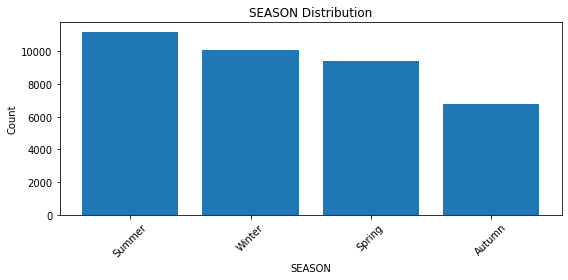

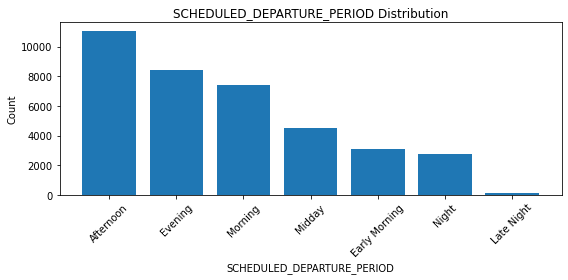

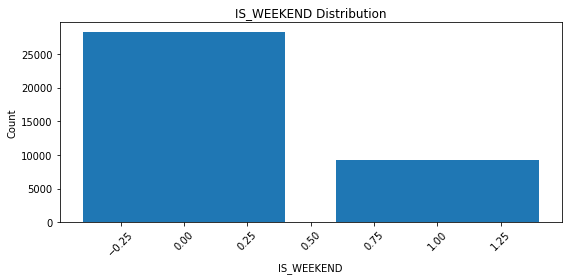

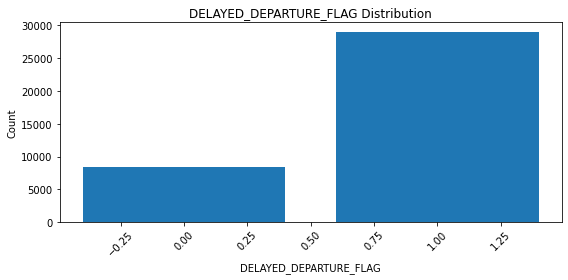

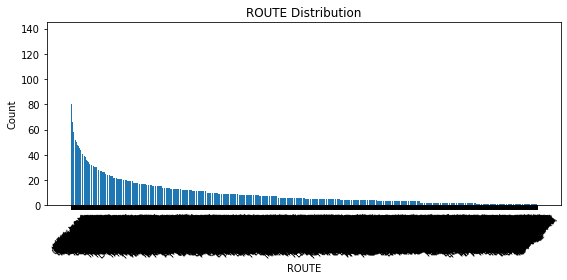

In [0]:
# List of categorical columns to plot
categorical_columns = [
    "SEASON",
    "SCHEDULED_DEPARTURE_PERIOD",
    "IS_WEEKEND",
    "DELAYED_DEPARTURE_FLAG",
    "ROUTE"
]

# Loop through and plot each
for column in categorical_columns:
    plot_categorical_distribution(
        cleaned_train_df,
        column_name=column,
        title=f"{column} Distribution",
        xlabel=column
    )

### HHMM columns to minutes from midnight

In [0]:
def hhmm_to_minutes(colname):
    return ((floor(col(colname) / 100) * 60 + (col(colname) % 100)) % 1440).alias(colname + "_min")

In [0]:
cleaned_train_df = cleaned_train_df.withColumn("SCHEDULED_DEPARTURE_min", hhmm_to_minutes("SCHEDULED_DEPARTURE"))
cleaned_train_df = cleaned_train_df.withColumn("SCHEDULED_ARRIVAL_min", hhmm_to_minutes("SCHEDULED_ARRIVAL"))
cleaned_train_df = cleaned_train_df.withColumn("DEPARTURE_TIME_min", hhmm_to_minutes("DEPARTURE_TIME"))
cleaned_train_df = cleaned_train_df.withColumn("WHEELS_OFF_min", hhmm_to_minutes("WHEELS_OFF"))
cleaned_train_df = cleaned_train_df.withColumn("ARRIVAL_TIME_min", hhmm_to_minutes("ARRIVAL_TIME"))
cleaned_train_df = cleaned_train_df.withColumn("DEPARTURE_TIME_min", hhmm_to_minutes("DEPARTURE_TIME"))

In [0]:
cleaned_val_df = cleaned_val_df.withColumn("SCHEDULED_DEPARTURE_min", hhmm_to_minutes("SCHEDULED_DEPARTURE"))
cleaned_val_df = cleaned_val_df.withColumn("SCHEDULED_ARRIVAL_min", hhmm_to_minutes("SCHEDULED_ARRIVAL"))
cleaned_val_df = cleaned_val_df.withColumn("DEPARTURE_TIME_min", hhmm_to_minutes("DEPARTURE_TIME"))
cleaned_val_df = cleaned_val_df.withColumn("WHEELS_OFF_min", hhmm_to_minutes("WHEELS_OFF"))
cleaned_val_df = cleaned_val_df.withColumn("ARRIVAL_TIME_min", hhmm_to_minutes("ARRIVAL_TIME"))
cleaned_val_df = cleaned_val_df.withColumn("DEPARTURE_TIME_min", hhmm_to_minutes("DEPARTURE_TIME"))

In [0]:
cleaned_test_df = cleaned_test_df.withColumn("SCHEDULED_DEPARTURE_min", hhmm_to_minutes("SCHEDULED_DEPARTURE"))
cleaned_test_df = cleaned_test_df.withColumn("SCHEDULED_ARRIVAL_min", hhmm_to_minutes("SCHEDULED_ARRIVAL"))
cleaned_test_df = cleaned_test_df.withColumn("DEPARTURE_TIME_min", hhmm_to_minutes("DEPARTURE_TIME"))
cleaned_test_df = cleaned_test_df.withColumn("WHEELS_OFF_min", hhmm_to_minutes("WHEELS_OFF"))
cleaned_test_df = cleaned_test_df.withColumn("ARRIVAL_TIME_min", hhmm_to_minutes("ARRIVAL_TIME"))
cleaned_test_df = cleaned_test_df.withColumn("DEPARTURE_TIME_min", hhmm_to_minutes("DEPARTURE_TIME"))

# 2.8 Outliers

In [0]:
# Get all numeric column names
numeric_features = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]

print("Numeric features:", numeric_features)

Numeric features: ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']


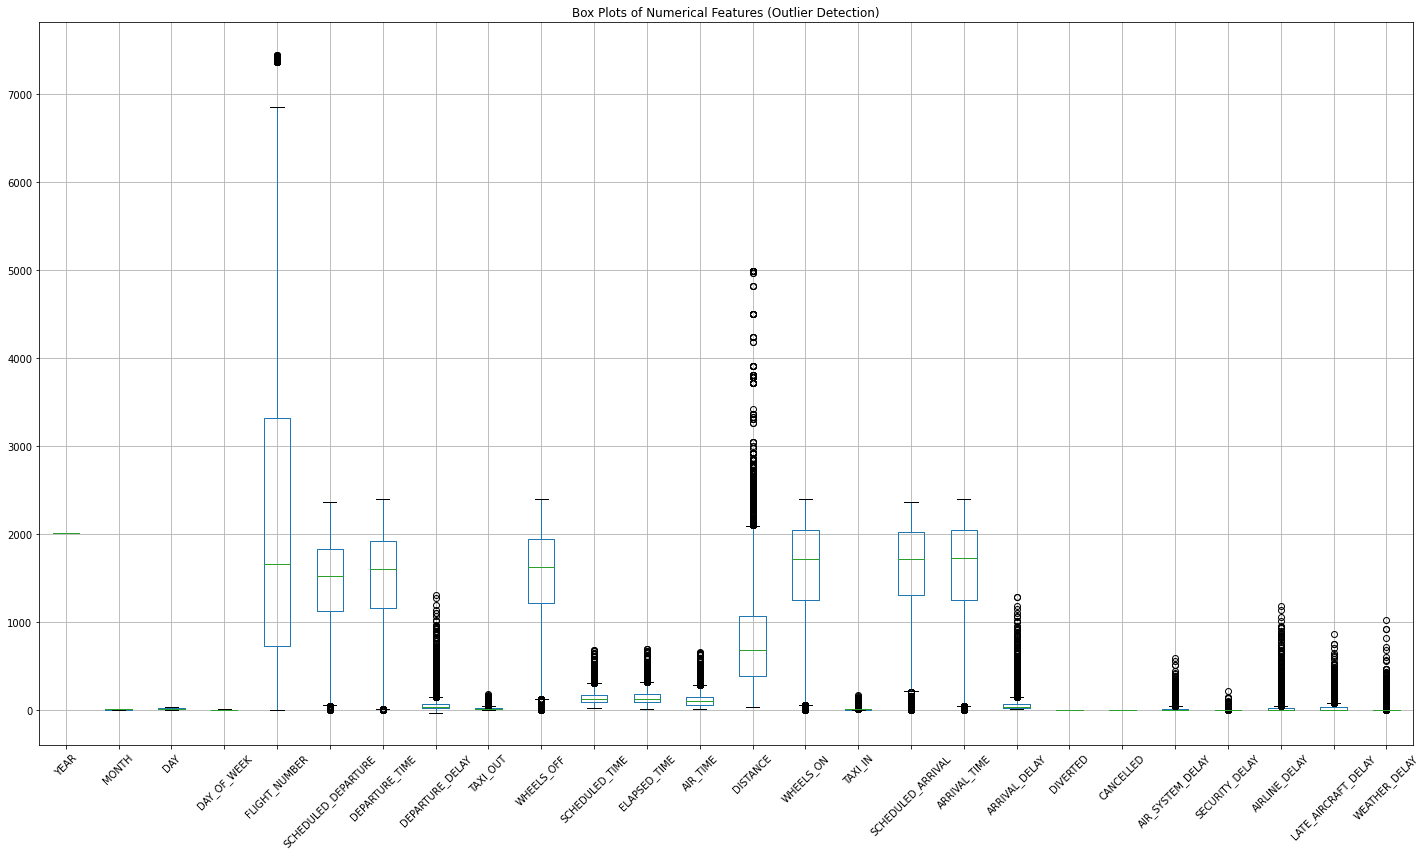

In [0]:
plot_df = cleaned_train_df.select(numeric_features).toPandas()

plt.figure(figsize=(20, 12))
plot_df.boxplot(rot=90)
plt.title("Box Plots of Numerical Features (Outlier Detection)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Functions

In [0]:
def cap_at_percentile(df, column, percentile):
    threshold = df.approxQuantile(column, [percentile], 0.01)[0]
    return df.withColumn(column, when(col(column) > threshold, threshold).otherwise(col(column)))


## Distance

In [0]:
# Mean, std, min, max
cleaned_train_df.select(
    mean("DISTANCE").alias("mean"),
    stddev("DISTANCE").alias("stddev"),
    min("DISTANCE").alias("min"),
    max("DISTANCE").alias("max")
).show()

# percentiles
percentiles = cleaned_train_df.approxQuantile("DISTANCE", [0.25, 0.5, 0.75, 0.95, 0.975, 0.99], 0.01)
q1, q2, q3, p95, p975, p99 = percentiles
iqr = q3 - q1

print(f"Q1 (25th percentile): {q1}")
print(f"Median (50th percentile): {q2}")
print(f"Q3 (75th percentile): {q3}")
print(f"IQR of DISTANCE: {iqr}")
print(f"95th percentile: {p95}")
print(f"97.5th percentile: {p975}")
print(f"99th percentile: {p99}")

+-----------------+-----------------+---+----+
|             mean|           stddev|min| max|
+-----------------+-----------------+---+----+
|833.8115040704657|609.7695134345798| 31|4983|
+-----------------+-----------------+---+----+

Q1 (25th percentile): 372.0
Median (50th percentile): 668.0
Q3 (75th percentile): 1055.0
IQR of DISTANCE: 683.0
95th percentile: 2105.0
97.5th percentile: 2419.0
99th percentile: 4983.0


In [0]:
# Total number of rows
total_count = cleaned_train_df.count()

# Count values above 95th and 97.5th percentile
above_95_count = cleaned_train_df.filter(col("DISTANCE") > p95).count()
above_975_count = cleaned_train_df.filter(col("DISTANCE") > p975).count()

# Calculate percentages
percent_above_95 = (above_95_count / total_count) * 100
percent_above_975 = (above_975_count / total_count) * 100

print(f"Percentage of values above 95th percentile: {percent_above_95:.2f}%")
print(f"Percentage of values above 97.5th percentile: {percent_above_975:.2f}%")

Percentage of values above 95th percentile: 5.96%
Percentage of values above 97.5th percentile: 3.43%


As observed in the boxplot, DISTANCE contains outliers. To reduce their impact on the model, we cap the values at the 97.5th percentile.


In [0]:
cleaned_train_df = cap_at_percentile(cleaned_train_df, "DISTANCE", 0.975)
cleaned_val_df = cap_at_percentile(cleaned_val_df, "DISTANCE", 0.975)
cleaned_test_df = cap_at_percentile(cleaned_test_df, "DISTANCE", 0.975)

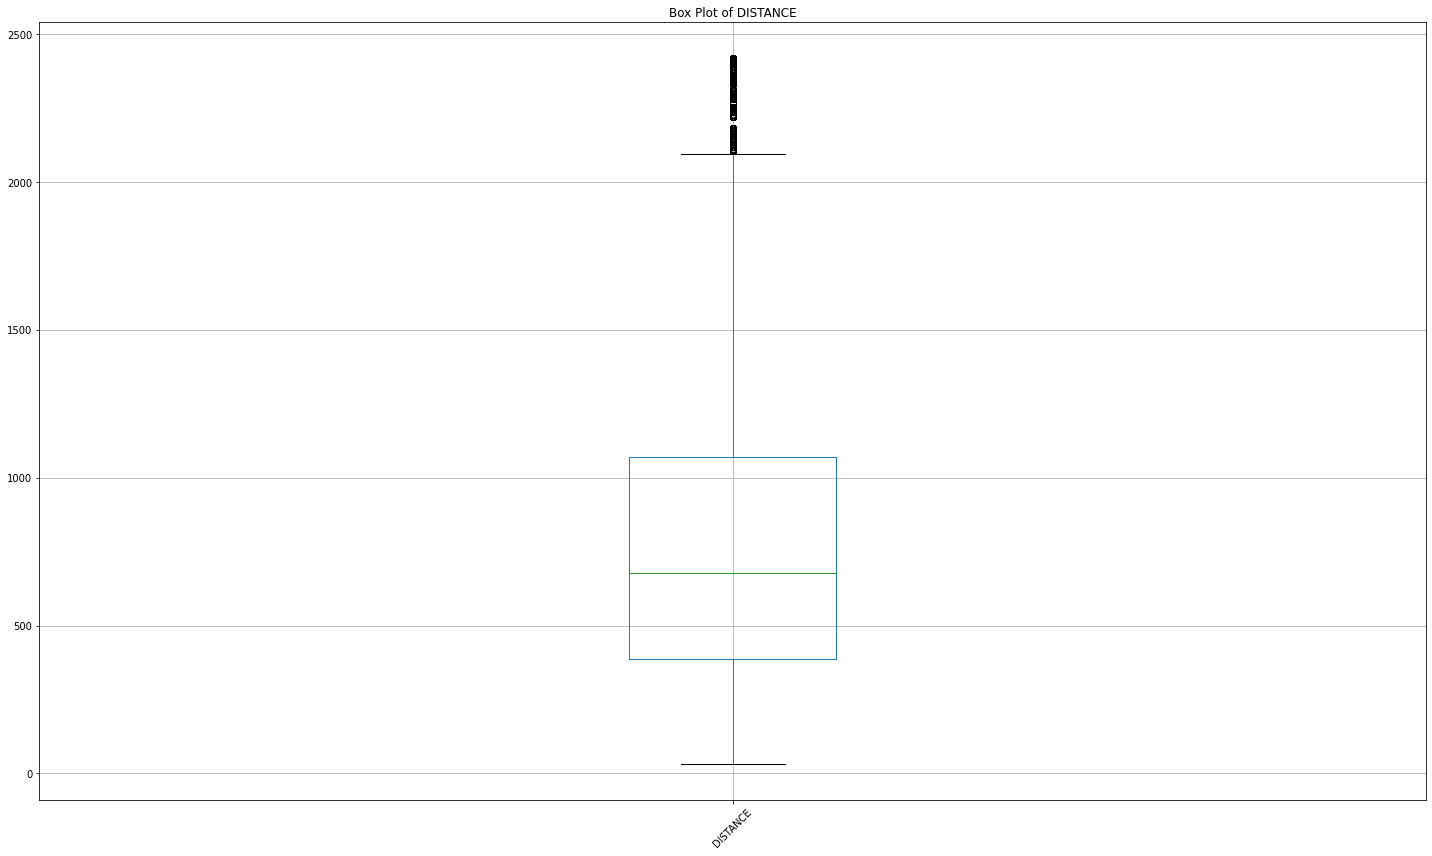

In [0]:
plot_df = cleaned_train_df.select("DISTANCE").toPandas()

plt.figure(figsize=(20, 12))
plot_df.boxplot(rot=90)
plt.title("Box Plot of DISTANCE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2.9 Encoding

## 2.9.1 Low Cardinality (One-Hot Encoding)

In [0]:
# List of low-cardinality features
low_cardinality_cols = ["SEASON", "SCHEDULED_DEPARTURE_PERIOD"]

# Apply StringIndexer and OneHotEncoder
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid='keep')
    for col in low_cardinality_cols]

encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec")
    for col in low_cardinality_cols]

# Build and apply the pipeline
pipeline = Pipeline(stages=indexers + encoders)
encoded_model = pipeline.fit(cleaned_train_df)

train_df_encoded = encoded_model.transform(cleaned_train_df)
val_df_encoded = encoded_model.transform(cleaned_val_df)
test_df_encoded = encoded_model.transform(cleaned_test_df)

## 2.9.2 High Cardinality (Frequency Encoding)

In [0]:
# High-cardinality columns
high_cardinality_cols = ["FLIGHT_NUMBER","TAIL_NUMBER", "AIRLINE", "ORIGIN_AIRPORT_CLEAN", "DESTINATION_AIRPORT_CLEAN", "ROUTE"]

# Apply frequency encoding
for column in high_cardinality_cols:
    freq_df = cleaned_train_df.groupBy(column).count()
    total = cleaned_train_df.count()
    
    # Add frequency column
    freq_df = freq_df.withColumn(f"{column}_freq", round(col("count") / total, 6)).drop("count")
    
    # Compute median frequency in training data
    median_freq = freq_df.approxQuantile(f"{column}_freq", [0.5], 0.001)[0]
    
    # Join frequency back to main DataFrame (in val and test, replace the freq of unseen values with the median in train)
    train_df_encoded = train_df_encoded.join(freq_df, on=column, how="left")
    val_df_encoded = val_df_encoded.join(freq_df, on=column, how="left").fillna({f"{column}_freq": median_freq})
    test_df_encoded = test_df_encoded.join(freq_df, on=column, how="left").fillna({f"{column}_freq": median_freq})

In [0]:
# Show final encoded columns
encoded_cols = [f"{column}_vec" for column in low_cardinality_cols] + \
               [f"{column}_freq" for column in high_cardinality_cols]

train_df_encoded.select(encoded_cols).limit(10).display()

SEASON_vec,SCHEDULED_DEPARTURE_PERIOD_vec,FLIGHT_NUMBER_freq,TAIL_NUMBER_freq,AIRLINE_freq,ORIGIN_AIRPORT_CLEAN_freq,DESTINATION_AIRPORT_CLEAN_freq,ROUTE_freq
"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",1.07E-4,1.33E-4,0.10407,1.07E-4,1.33E-4,2.7E-5
"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(6), values -> List(1.0))",4.0E-4,2.14E-4,0.055412,2.67E-4,0.022821,8.0E-5
"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",5.87E-4,1.87E-4,0.055412,2.67E-4,0.02106,1.87E-4
"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",5.87E-4,4.0E-4,0.055412,2.67E-4,0.02106,1.87E-4
"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",5.87E-4,2.4E-4,0.055412,2.67E-4,0.02106,1.87E-4
"Map(vectorType -> sparse, length -> 4, indices -> List(2), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",5.87E-4,2.94E-4,0.055412,2.67E-4,0.02106,1.87E-4
"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))",5.87E-4,4.0E-4,0.055412,2.67E-4,0.02106,1.87E-4
"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",1.07E-4,4.27E-4,0.10407,1.07E-4,0.017857,8.0E-5
"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",1.07E-4,1.33E-4,0.10407,1.07E-4,0.017857,8.0E-5
"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",1.07E-4,2.67E-4,0.10407,1.07E-4,0.017857,8.0E-5


### Check Unseen Values in Val

In [0]:
from pyspark.sql.functions import expr, col

freq_columns = [f"{col}_freq" for col in high_cardinality_cols]

print(f"Median of _freq columns in train:")
for freq_col in freq_columns:
    median_val = train_df_encoded.approxQuantile(freq_col, [0.5], 0.001)[0]
    print(f"{freq_col}: {median_val}")

Median of _freq columns in train:
FLIGHT_NUMBER_freq: 0.00024
TAIL_NUMBER_freq: 0.000294
AIRLINE_freq: 0.10407
ORIGIN_AIRPORT_CLEAN_freq: 0.020099
DESTINATION_AIRPORT_CLEAN_freq: 0.017857
ROUTE_freq: 0.000454


In [0]:
# total rows in val to calculate frequency
val_total = val_df_encoded.count()  

for col_name in high_cardinality_cols:
    print(f"Top 5 unseen values in val for column: {col_name}")
    
    # Distinct train values
    train_values = cleaned_train_df.select(col_name).distinct()
    
    # Count per val value
    val_counts = val_df_encoded.groupBy(col_name).count()
    
    # Unseen in train
    unseen_vals = val_counts.join(train_values, on=col_name, how='left_anti')
    
    # Add relative frequency column, sort and show top 5
    unseen_vals = unseen_vals.withColumn("frequency", round(col("count") / val_total, 6)) \
                             .orderBy(desc("count")) \
                             .limit(5)
    
    unseen_vals.show(truncate=False)

Top 5 unseen values in val for column: FLIGHT_NUMBER
+-------------+-----+---------+
|FLIGHT_NUMBER|count|frequency|
+-------------+-----+---------+
|4167         |3    |3.74E-4  |
|5547         |3    |3.74E-4  |
|5245         |3    |3.74E-4  |
|6195         |3    |3.74E-4  |
|4577         |3    |3.74E-4  |
+-------------+-----+---------+

Top 5 unseen values in val for column: TAIL_NUMBER
+-----------+-----+---------+
|TAIL_NUMBER|count|frequency|
+-----------+-----+---------+
|N19141     |3    |3.74E-4  |
|N624AG     |2    |2.49E-4  |
|N585SW     |2    |2.49E-4  |
|N640AA     |1    |1.25E-4  |
|N76054     |1    |1.25E-4  |
+-----------+-----+---------+

Top 5 unseen values in val for column: AIRLINE
+-------+-----+---------+
|AIRLINE|count|frequency|
+-------+-----+---------+
+-------+-----+---------+

Top 5 unseen values in val for column: ORIGIN_AIRPORT_CLEAN
+--------------------+-----+---------+
|ORIGIN_AIRPORT_CLEAN|count|frequency|
+--------------------+-----+---------+
|DLG   

# 2.10 Coherence Checking

## 2.10.1 Duplicated rows (after mapping airports)

We noticed airport codes repeated so we have to treat that

In [0]:
duplicate_indexes_train = (
    train_df_encoded.groupBy("index")
    .agg(count("*").alias("count"))
    .filter(col("count") > 1)
)

print("Duplicate indexes in train_df:")
duplicate_indexes_train.limit(10).display()

Duplicate indexes in train_df:


index,count
1022,2
1058,2
2373,2
2374,2
2413,2
2421,2
3905,2
5091,2
5116,2
6286,2


In [0]:
duplicate_rows = train_df_encoded.join(
    duplicate_indexes_train.select("index"),
    on="index",
    how="inner")
    
columns_to_show = [
    "index", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT",
    "ORIGIN_AIRPORT_CLEAN", "DESTINATION_AIRPORT_CLEAN"
]

duplicate_rows.select(columns_to_show).limit(10).display()

index,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ORIGIN_AIRPORT_CLEAN,DESTINATION_AIRPORT_CLEAN
1022,10423,10693,AUS,BNA
1022,10423,10693,BSM,BNA
1058,12173,12982,HIK,LIH
1058,12173,12982,HNL,LIH
2373,10423,11259,AUS,DAL
2373,10423,11259,BSM,DAL
2374,10423,13930,AUS,ORD
2374,10423,13930,BSM,ORD
2413,12478,12173,JFK,HIK
2413,12478,12173,JFK,HNL


In [0]:
origin_train_mapping = (
    train_df_encoded.groupBy("ORIGIN_AIRPORT")
    .agg(min("ORIGIN_AIRPORT_CLEAN").alias("PREFERRED_ORIGIN_AIRPORT_CLEAN"))
)

destination_train_mapping = (
    train_df_encoded.groupBy("DESTINATION_AIRPORT")
    .agg(min("DESTINATION_AIRPORT_CLEAN").alias("PREFERRED_DESTINATION_AIRPORT_CLEAN"))
)

# Join and overwrite ORIGIN_AIRPORT_CLEAN
train_df_encoded = train_df_encoded.join(
    origin_train_mapping, on="ORIGIN_AIRPORT", how="left"
)

# Join and overwrite DESTINATION_AIRPORT_CLEAN
train_df_encoded = train_df_encoded.join(
    destination_train_mapping, on="DESTINATION_AIRPORT", how="left"
)

In [0]:
duplicate_rows = train_df_encoded.join(
    duplicate_indexes_train.select("index"),
    on="index",
    how="inner")

columns_to_show = [
    "index", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT",
    "ORIGIN_AIRPORT_CLEAN", "DESTINATION_AIRPORT_CLEAN", 
    "PREFERRED_ORIGIN_AIRPORT_CLEAN", "PREFERRED_DESTINATION_AIRPORT_CLEAN"
]

duplicate_rows.select(columns_to_show).limit(10).display()

index,ORIGIN_AIRPORT,DESTINATION_AIRPORT,ORIGIN_AIRPORT_CLEAN,DESTINATION_AIRPORT_CLEAN,PREFERRED_ORIGIN_AIRPORT_CLEAN,PREFERRED_DESTINATION_AIRPORT_CLEAN
37267,10397,10423,ATL,AUS,ATL,AUS
37267,10397,10423,ATL,BSM,ATL,AUS
37268,10397,10423,ATL,AUS,ATL,AUS
37268,10397,10423,ATL,BSM,ATL,AUS
1022,10423,10693,AUS,BNA,AUS,BNA
1022,10423,10693,BSM,BNA,AUS,BNA
2373,10423,11259,AUS,DAL,AUS,DAL
2373,10423,11259,BSM,DAL,AUS,DAL
2374,10423,13930,AUS,ORD,AUS,ORD
2374,10423,13930,BSM,ORD,AUS,ORD


In [0]:
cleaned_train_df = train_df_encoded.filter(
    (col("ORIGIN_AIRPORT_CLEAN") == col("PREFERRED_ORIGIN_AIRPORT_CLEAN")) &
    (col("DESTINATION_AIRPORT_CLEAN") == col("PREFERRED_DESTINATION_AIRPORT_CLEAN"))
)

cleaned_train_df = cleaned_train_df.drop(
    "PREFERRED_ORIGIN_AIRPORT_CLEAN",
    "PREFERRED_DESTINATION_AIRPORT_CLEAN"
)

In [0]:
origin_val_mapping = (
    val_df_encoded.groupBy("ORIGIN_AIRPORT")
    .agg(min("ORIGIN_AIRPORT_CLEAN").alias("PREFERRED_ORIGIN_AIRPORT_CLEAN"))
)

destination_val_mapping = (
    val_df_encoded.groupBy("DESTINATION_AIRPORT")
    .agg(min("DESTINATION_AIRPORT_CLEAN").alias("PREFERRED_DESTINATION_AIRPORT_CLEAN"))
)

# Join and overwrite ORIGIN_AIRPORT_CLEAN
val_df_encoded = val_df_encoded.join(
    origin_val_mapping, on="ORIGIN_AIRPORT", how="left"
)

# Join and overwrite DESTINATION_AIRPORT_CLEAN
val_df_encoded = val_df_encoded.join(
    destination_val_mapping, on="DESTINATION_AIRPORT", how="left"
)

cleaned_val_df = val_df_encoded.filter(
    (col("ORIGIN_AIRPORT_CLEAN") == col("PREFERRED_ORIGIN_AIRPORT_CLEAN")) &
    (col("DESTINATION_AIRPORT_CLEAN") == col("PREFERRED_DESTINATION_AIRPORT_CLEAN"))
)

cleaned_val_df = cleaned_val_df.drop(
    "PREFERRED_ORIGIN_AIRPORT_CLEAN",
    "PREFERRED_DESTINATION_AIRPORT_CLEAN"
)

In [0]:
origin_test_mapping = (
    test_df_encoded.groupBy("ORIGIN_AIRPORT")
    .agg(min("ORIGIN_AIRPORT_CLEAN").alias("PREFERRED_ORIGIN_AIRPORT_CLEAN"))
)

destination_test_mapping = (
    test_df_encoded.groupBy("DESTINATION_AIRPORT")
    .agg(min("DESTINATION_AIRPORT_CLEAN").alias("PREFERRED_DESTINATION_AIRPORT_CLEAN"))
)

# Join and overwrite ORIGIN_AIRPORT_CLEAN
test_df_encoded = test_df_encoded.join(
    origin_test_mapping, on="ORIGIN_AIRPORT", how="left"
)

# Join and overwrite DESTINATION_AIRPORT_CLEAN
test_df_encoded = test_df_encoded.join(
    destination_test_mapping, on="DESTINATION_AIRPORT", how="left"
)

cleaned_test_df = test_df_encoded.filter(
    (col("ORIGIN_AIRPORT_CLEAN") == col("PREFERRED_ORIGIN_AIRPORT_CLEAN")) &
    (col("DESTINATION_AIRPORT_CLEAN") == col("PREFERRED_DESTINATION_AIRPORT_CLEAN"))
)

cleaned_test_df = cleaned_test_df.drop(
    "PREFERRED_ORIGIN_AIRPORT_CLEAN",
    "PREFERRED_DESTINATION_AIRPORT_CLEAN"
)

In [0]:
total_train_rows = cleaned_train_df.count()
total_val_rows = cleaned_val_df.count()
total_test_rows = cleaned_test_df.count()

print(f"train_df → total: {total_train_rows}")
print(f"val_df → total: {total_val_rows}")
print(f"test_df → total: {total_test_rows}")

train_df → total: 37396
val_df → total: 8013
test_df → total: 8020


## 2.10.2 Columns and datatypes

In [0]:
#checking if all datasets have the same number of columns
train_cols_count = len(cleaned_train_df.columns)
val_cols_count = len(cleaned_val_df.columns)
test_cols_count = len(cleaned_test_df.columns)

if train_cols_count == val_cols_count == test_cols_count:
    print("All datasets have the same number of columns")
else:
    print("Datasets have different columns")


In [0]:
#check if the columns and datatypes match
train_cols = set(cleaned_train_df.dtypes)
val_cols = set(cleaned_val_df.dtypes)
test_cols = set(cleaned_test_df.dtypes)

if train_cols == val_cols == test_cols:
    print("All datasets have matching columns and data types.")
else:
    print("There are differences in columns or data types.")

## 2.10.3 Null values

In [0]:
#function to check the presence of NaN values or null values
def check_missing_values(df, df_name):
    print(f"Missing values in {df_name}:")

    # Split columns by type
    numeric_types = ['int', 'double', 'bigint', 'float']
    string_cols = [c for c, t in df.dtypes if t == 'string']
    numeric_cols = [c for c, t in df.dtypes if t in numeric_types]
    vector_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, VectorUDT)]

    #check Null and NaN for numeric
    numeric_missing = df.select([
        count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in numeric_cols
    ])

    # check only null for string
    string_missing = df.select([
        count(when(col(c).isNull(), c)).alias(c) for c in string_cols
    ])

    # check nulls in vector columns 
    vector_missing = df.select([
        count(when(col(c).isNull(), c)).alias(c) for c in vector_cols
    ])

    # Display both
    print("Numeric columns:")
    display(numeric_missing)
    print("String columns:")
    display(string_missing)
    print("Vector columns:")
    display(vector_missing)


In [0]:
check_missing_values(cleaned_train_df, "cleaned_train_df")
check_missing_values(cleaned_val_df, "cleaned_val_df")
check_missing_values(cleaned_test_df, "cleaned_test_df")


**Conclusion**: No missing values

## 2.10.4 Unique values

In [0]:
#check the number of unique values in each column
unique_counts = cleaned_train_df.select([
    countDistinct(col).alias(col) for col in cleaned_train_df.columns
])
display(unique_counts)

In [0]:
#check if the values in each column make sense
for col_name in cleaned_train_df.columns:
    print(f"Unique values in column: {col_name}")
    cleaned_train_df.select(col_name).distinct().limit(10).display()

In [0]:
numeric_types = ['int', 'bigint', 'double']
numeric_cols = [c for c, t in cleaned_train_df.dtypes if t in numeric_types]

stats = []
for c in numeric_cols:
    zero_count = cleaned_train_df.filter(col(c) == 0).count()
    neg_count = cleaned_train_df.filter(col(c) < 0).count()
    stats.append((c, zero_count > 0, neg_count > 0, zero_count, neg_count))

result_df = spark.createDataFrame(stats, schema=["column", "has_zero", "has_negative", "zero_count", "negative_count"])
result_df.limit(10).display()

## 2.10.5 Time columns

### Schedule vs Actual Departure Time

In [0]:
#check if the scheduled departure plus the delay equals the departure time

# 2400 corresponds to 24:00 (midnight) that is 1440 minutes but we want it to be 0
# Apply modulo 1440 to wrap around expected departure time
df_check = cleaned_train_df.withColumn(
    "EXPECTED_DEPARTURE_TIME_min",
    expr("((SCHEDULED_DEPARTURE_min + DEPARTURE_DELAY) % 1440)")
)

# Check the difference from actual departure
df_check = df_check.withColumn(
    "DIFF_MINUTES",
    col("EXPECTED_DEPARTURE_TIME_min") - col("DEPARTURE_TIME_min")
)

# Show mismatches
df_check.select(
    "SCHEDULED_DEPARTURE_min", "DEPARTURE_DELAY", "DEPARTURE_TIME_min",
    "EXPECTED_DEPARTURE_TIME_min", "DIFF_MINUTES"
).orderBy(expr("abs(DIFF_MINUTES)").desc()).show()

# Check if there are any mismatches
mismatches = df_check.filter(expr("DIFF_MINUTES != 0")).count()

if mismatches > 0:
    print(f"There are {mismatches} mismatch(es) between expected and actual departure times.")
else:
    print("No mismatches — the times match exactly.")

+-----------------------+---------------+------------------+---------------------------+------------+
|SCHEDULED_DEPARTURE_min|DEPARTURE_DELAY|DEPARTURE_TIME_min|EXPECTED_DEPARTURE_TIME_min|DIFF_MINUTES|
+-----------------------+---------------+------------------+---------------------------+------------+
|                    360|             -7|               353|                        353|           0|
|                    555|              9|               564|                        564|           0|
|                    960|            195|              1155|                       1155|           0|
|                    493|            323|               816|                        816|           0|
|                   1106|             68|              1174|                       1174|           0|
|                    450|             29|               479|                        479|           0|
|                    790|             50|               840|                      

We verified that the feature DEPARTURE_TIME aligns with the sum of SCHEDULED_DEPARTURE and DEPARTURE_DELAY. This confirms that the delay information is correctly encoded, and no mismatches were detected.

### Consistency Between Scheduled Times (Departure and Arrival)

In [0]:
df_check = cleaned_train_df.withColumn(
    "EXPECTED_ARRIVAL_TIME_min",
    ((col("SCHEDULED_DEPARTURE_min") + col("SCHEDULED_TIME")) % 1440)
).withColumn(
    "DIFF_MINUTES",
    col("SCHEDULED_ARRIVAL_min") - col("EXPECTED_ARRIVAL_TIME_min")

)

# Show mismatches
df_check.select(
    "SCHEDULED_DEPARTURE_min", "SCHEDULED_TIME", "SCHEDULED_ARRIVAL_min",
    "EXPECTED_ARRIVAL_TIME_min", "DIFF_MINUTES"
).orderBy(expr("abs(DIFF_MINUTES)").desc()).limit(10).display()

# Count mismatches (non-zero differences)
mismatches = df_check.filter(col("DIFF_MINUTES") != 0).count()
total = df_check.count()

# Print result
if mismatches == 0:
    print("No mismatches: scheduled arrival time matches the sum of scheduled departure and scheduled time.")
else:
    print(f"Found {mismatches} mismatches in {total}: arrival time does not match expected value in some rows.")



SCHEDULED_DEPARTURE_min,SCHEDULED_TIME,SCHEDULED_ARRIVAL_min,EXPECTED_ARRIVAL_TIME_min,DIFF_MINUTES
1311,149,1400,20,1380
1320,160,1420,40,1380
1310,105,35,1415,-1380
1325,143,1408,28,1380
1320,90,30,1410,-1380
1335,116,1391,11,1380
1270,170,1380,0,1380
1310,130,1380,0,1380
1330,54,4,1384,-1380
1255,140,15,1395,-1380


Found 18320 mismatches in 37396: arrival time does not match expected value in some rows.


In [0]:
mismatches = df_check.filter(col("DIFF_MINUTES") != 0)

# Group by the difference value and count how many times each occurs
mismatches.groupBy("DIFF_MINUTES").count().orderBy("DIFF_MINUTES").limit(10).display()

DIFF_MINUTES,count
-1380,193
-1320,119
-1260,79
-360,6
-300,25
-240,16
-180,967
-120,1782
-60,5560
60,5838


The discrepancies observed between the expected and scheduled arrival times are likely due to differences in time zones between departure and arrival airports. This is supported by the fact that many mismatches consistently differ by 60-minute intervals, which aligns with typical time zone offsets.

In [0]:
mismatches = df_check.filter(col("DIFF_MINUTES") != 0)
mismatches.select("ROUTE", "DIFF_MINUTES").limit(10).display()

ROUTE,DIFF_MINUTES
ABQ_MCI,60
ABQ_DAL,60
ABQ_LAX,-60
ABQ_MCI,60
AEX_ATL,60
AEX_ATL,60
ATL_GTR,-60
ATL_MCI,-60
ATL_ORD,-60
ATL_LFT,-60


ABQ_MCI
( Albuquerque International Sunport - Kansas City International Airport )
<br>
Time Zone Difference: +1 (= 60 minutes)

ABQ_DAL
( Albuquerque International Sunport - Dallas Love Field )
<br>
Time Zone Difference: +1 (= 60 minutes)

ABQ_LAX
( Albuquerque International Sunport - Los Angeles International Airport )
<br>
Time Zone Difference: -1 (= -60 minutes)

<br>
This discrepancie is due to time zone differences, it isn't an incoherence in our dataset.

### Negative delays

In [0]:
#rows in which departure delay is negative, the flights departure before their scheduled time
cleaned_train_df \
    .filter(col("DEPARTURE_DELAY") < 0) \
    .select("DEPARTURE_DELAY", "SCHEDULED_DEPARTURE_min","DEPARTURE_TIME_min") \
    .distinct() \
    .orderBy("DEPARTURE_DELAY") \
    .limit(10) \
    .display()

count = cleaned_train_df.filter(col("DEPARTURE_DELAY") < -10).count()

print(f"Number of rows with DEPARTURE_DELAY < -10: {count}") #since it is a small number of rows in comparison with the total number of rows, we will cap all values above -10 to this value

DEPARTURE_DELAY,SCHEDULED_DEPARTURE_min,DEPARTURE_TIME_min
-29,490,461
-25,1052,1027
-24,486,462
-21,158,137
-21,1385,1364
-21,1026,1005
-17,1219,1202
-16,1425,1409
-16,420,404
-15,440,425


Number of rows with DEPARTURE_DELAY < -10: 98


In [0]:
cleaned_train_df = cleaned_train_df.filter(col("DEPARTURE_DELAY") >= -10)
cleaned_val_df = cleaned_val_df.filter(col("DEPARTURE_DELAY") >= -10)
cleaned_test_df = cleaned_test_df.filter(col("DEPARTURE_DELAY") >= -10)

## 2.10.6 Delays

In [0]:
#check if there are no delays then the scheduled arrival is equal to the arrival time
cleaned_train_df.filter(
    (cleaned_train_df.AIR_SYSTEM_DELAY == 0) &
    (cleaned_train_df.SECURITY_DELAY == 0) &
    (cleaned_train_df.AIRLINE_DELAY == 0) &
    (cleaned_train_df.LATE_AIRCRAFT_DELAY == 0) &
    (cleaned_train_df.WEATHER_DELAY == 0) &
    ((cleaned_train_df.SCHEDULED_ARRIVAL != cleaned_train_df.ARRIVAL_TIME) | (cleaned_train_df.SCHEDULED_DEPARTURE != cleaned_train_df.DEPARTURE_TIME))
).limit(10).display()
# 0 rows, no incoherence

# 2.11 Drop Features and Feature Treatment


We aim to predict **ARRIVAL_DELAY** for flights after departure has already occurred. This means that we can safely use any features that become available after the flight takes off.

However, to avoid data leakage, we must still exclude variables that contain or imply the final arrival delay itself, or any information that can only be known after landing.

---

## Features to Exclude (Post Arrival Information or Leakage Risk)

| Feature                | Reason for Exclusion                                                                 |
|------------------------|---------------------------------------------------------------------------------------|
| ARRIVAL_TIME         | Actual arrival time — directly reveals the target.                                   |
| TAXI_IN              | Time spent taxiing after landing — only known after arrival.                         |
| WHEELS_ON            | Time the aircraft touched the runway — post-flight metric.                           |
| ELAPSED_TIME         | Total actual time of flight — includes arrival info.                                 |
| CANCELLED            | Indicates flight didn’t operate — not relevant when flight has already departed.     |
| DIVERTED             | Only known after the flight ends — may distort predictions if included.              |
| AIR_TIME             | Only known after the flight ends — reflects the actual flying duration from WHEELS_OFF to WHEELS_ON             |

We do not exclude ARRIVAL_DELAY, TOTAL_KNOWN_DELAY, AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY and WEATHER_DELAY because these features are going to be used later on to define target variables.

In [0]:
cleaned_train_df.columns

Out[113]: ['DESTINATION_AIRPORT',
 'ORIGIN_AIRPORT',
 'ROUTE',
 'DESTINATION_AIRPORT_CLEAN',
 'ORIGIN_AIRPORT_CLEAN',
 'AIRLINE',
 'TAIL_NUMBER',
 'FLIGHT_NUMBER',
 'index',
 'YEAR',
 'MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'SCHEDULED_DEPARTURE',
 'DEPARTURE_TIME',
 'DEPARTURE_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'SCHEDULED_TIME',
 'ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'WHEELS_ON',
 'TAXI_IN',
 'SCHEDULED_ARRIVAL',
 'ARRIVAL_TIME',
 'ARRIVAL_DELAY',
 'DIVERTED',
 'CANCELLED',
 'AIR_SYSTEM_DELAY',
 'SECURITY_DELAY',
 'AIRLINE_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'WEATHER_DELAY',
 'SEASON',
 'SCHEDULED_DEPARTURE_PERIOD',
 'IS_WEEKEND',
 'DELAYED_DEPARTURE_FLAG',
 'TOTAL_KNOWN_DELAY',
 'SCHEDULED_DEPARTURE_min',
 'SCHEDULED_ARRIVAL_min',
 'DEPARTURE_TIME_min',
 'WHEELS_OFF_min',
 'ARRIVAL_TIME_min',
 'SEASON_index',
 'SCHEDULED_DEPARTURE_PERIOD_index',
 'SEASON_vec',
 'SCHEDULED_DEPARTURE_PERIOD_vec',
 'FLIGHT_NUMBER_freq',
 'TAIL_NUMBER_freq',
 'AIRLINE_freq',
 'ORIGIN_AIRPORT_CLEAN_freq',
 '

In [0]:
# List of columns to drop
cols_to_drop = [
    "ARRIVAL_TIME",
    "TAXI_IN",
    "WHEELS_ON",
    "ELAPSED_TIME",
    "CANCELLED",
    "DIVERTED",
    "AIR_TIME"]

# Drop from DataFrames
cleaned_train_df = cleaned_train_df.drop(*cols_to_drop)
cleaned_val_df = cleaned_val_df.drop(*cols_to_drop)
cleaned_test_df = cleaned_test_df.drop(*cols_to_drop)

In [0]:
# Define columns to drop
cols_to_drop = [
    # 'YEAR',
    # 'MONTH',
    # 'DAY',
    'SEASON_index',
    'SCHEDULED_DEPARTURE_PERIOD_index',
    'TAIL_NUMBER', 
    'ORIGIN_AIRPORT', # wrong one
    'DESTINATION_AIRPORT', # wrong one
    "SCHEDULED_DEPARTURE", # HHMM
    "SCHEDULED_ARRIVAL", # HHMM
    "DEPARTURE_TIME", # HHMM
    "WHEELS_OFF" # HHMM
]

# Drop from DataFrames
cleaned_train_df = cleaned_train_df.drop(*cols_to_drop)
cleaned_val_df = cleaned_val_df.drop(*cols_to_drop)
cleaned_test_df = cleaned_test_df.drop(*cols_to_drop)

cols_to_drop

Out[115]: ['SEASON_index',
 'SCHEDULED_DEPARTURE_PERIOD_index',
 'TAIL_NUMBER',
 'ORIGIN_AIRPORT',
 'DESTINATION_AIRPORT',
 'SCHEDULED_DEPARTURE',
 'SCHEDULED_ARRIVAL',
 'DEPARTURE_TIME',
 'WHEELS_OFF']

# 2.12 Rename Columns

In [0]:
# Rename columns for clarity
cleaned_train_df = cleaned_train_df.withColumnRenamed("ORIGIN_AIRPORT_CLEAN_freq", "ORIGIN_AIRPORT_freq")
cleaned_train_df = cleaned_train_df.withColumnRenamed("DESTINATION_AIRPORT_CLEAN_freq", "DESTINATION_AIRPORT_freq")
cleaned_val_df = cleaned_val_df.withColumnRenamed("ORIGIN_AIRPORT_CLEAN_freq", "ORIGIN_AIRPORT_freq")
cleaned_val_df = cleaned_val_df.withColumnRenamed("DESTINATION_AIRPORT_CLEAN_freq", "DESTINATION_AIRPORT_freq")
cleaned_test_df = cleaned_test_df.withColumnRenamed("ORIGIN_AIRPORT_CLEAN_freq", "ORIGIN_AIRPORT_freq")
cleaned_test_df = cleaned_test_df.withColumnRenamed("DESTINATION_AIRPORT_CLEAN_freq", "DESTINATION_AIRPORT_freq")

In [0]:
cleaned_train_df = cleaned_train_df.withColumnRenamed("ORIGIN_AIRPORT_CLEAN", "ORIGIN_AIRPORT")
cleaned_train_df = cleaned_train_df.withColumnRenamed("DESTINATION_AIRPORT_CLEAN", "DESTINATION_AIRPORT")
cleaned_val_df = cleaned_val_df.withColumnRenamed("ORIGIN_AIRPORT_CLEAN", "ORIGIN_AIRPORT")
cleaned_val_df = cleaned_val_df.withColumnRenamed("DESTINATION_AIRPORT_CLEAN", "DESTINATION_AIRPORT")
cleaned_test_df = cleaned_test_df.withColumnRenamed("ORIGIN_AIRPORT_CLEAN", "ORIGIN_AIRPORT")
cleaned_test_df = cleaned_test_df.withColumnRenamed("DESTINATION_AIRPORT_CLEAN", "DESTINATION_AIRPORT")

# 2.13 Export Dataframe

In [0]:
# Export train DataFrame as a Delta table
cleaned_train_df.write.mode("overwrite") \
    .option("overwriteSchema", "true") \
    .format("delta") \
    .save("/dbfs/FileStore/tables/train_df")

# Export val DataFrame as a Delta tablecleaned_
cleaned_val_df.write.mode("overwrite") \
    .option("overwriteSchema", "true") \
    .format("delta") \
    .save("/dbfs/FileStore/tables/val_df")

# Export test DataFrame as a Delta tablecleaned_
cleaned_test_df.write.mode("overwrite") \
    .option("overwriteSchema", "true") \
    .format("delta") \
    .save("/dbfs/FileStore/tables/test_df")


In [0]:
cleaned_train_df.limit(10).display()

ROUTE,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIRLINE,FLIGHT_NUMBER,index,YEAR,MONTH,DAY,DAY_OF_WEEK,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,DISTANCE,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SEASON,SCHEDULED_DEPARTURE_PERIOD,IS_WEEKEND,DELAYED_DEPARTURE_FLAG,TOTAL_KNOWN_DELAY,SCHEDULED_DEPARTURE_min,SCHEDULED_ARRIVAL_min,DEPARTURE_TIME_min,WHEELS_OFF_min,ARRIVAL_TIME_min,SEASON_vec,SCHEDULED_DEPARTURE_PERIOD_vec,FLIGHT_NUMBER_freq,TAIL_NUMBER_freq,AIRLINE_freq,ORIGIN_AIRPORT_freq,DESTINATION_AIRPORT_freq,ROUTE_freq
ACY_FLL,FLL,ACY,NK,235,1,2015,1,1,4,89,9,165,977.0,86,86,0,0,0,0,Winter,Midday,0,1,86,755,920,844,853,1006,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(3), values -> List(1.0))",3.2E-4,3.47E-4,0.031523,7.47E-4,0.016228,1.07E-4
ANC_ORD,ORD,ANC,UA,1562,2,2015,1,1,4,39,23,357,2419.0,21,0,0,18,3,0,Winter,Evening,0,1,21,1223,320,1262,1285,341,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0))",2.94E-4,2.14E-4,0.097264,0.001975,0.057547,3.47E-4
ATL_TPA,TPA,ATL,DL,1491,3,2015,1,1,4,49,16,85,406.0,43,0,0,0,43,0,Winter,Evening,0,1,43,1085,1170,1134,1150,1213,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0))",3.74E-4,1.07E-4,0.109462,0.054451,0.011744,0.001201
BOS_DTW,DTW,BOS,B6,1837,4,2015,1,1,4,9,24,137,632.0,25,16,9,0,0,0,Winter,Evening,0,0,25,1195,1332,1204,1228,1357,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0))",1.87E-4,3.74E-4,0.055412,0.020259,0.017937,6.14E-4
BOS_JFK,JFK,BOS,AA,1096,5,2015,1,1,4,38,14,90,187.0,26,0,0,2,24,0,Winter,Afternoon,0,1,26,1065,1155,1103,1117,1181,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",2.67E-4,2.67E-4,0.122488,0.020259,0.02106,0.001281
BOS_MCO,MCO,BOS,B6,951,6,2015,1,1,4,73,23,206,1121.0,59,0,0,55,4,0,Winter,Afternoon,0,1,59,953,1159,1026,1049,1218,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",2.4E-4,1.87E-4,0.055412,0.020259,0.022821,5.07E-4
BOS_MIA,MIA,BOS,AA,1533,7,2015,1,1,4,68,15,215,1258.0,53,0,0,0,53,0,Winter,Afternoon,0,1,53,1025,1240,1093,1108,1293,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(0), values -> List(1.0))",1.6E-4,5.3E-5,0.122488,0.020259,0.013746,3.47E-4
BWI_JAX,JAX,BWI,WN,125,8,2015,1,1,4,35,19,125,663.0,37,2,0,35,0,0,Winter,Evening,0,1,37,1220,1345,1255,1274,1382,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0))",3.47E-4,4.0E-4,0.224236,0.020099,0.00395,3.74E-4
BWI_SAN,SAN,BWI,WN,1129,9,2015,1,1,4,5,10,355,2295.0,17,17,0,0,0,0,Winter,Evening,0,0,17,1095,1270,1100,1110,1287,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0))",3.47E-4,2.67E-4,0.224236,0.020099,0.013693,1.6E-4
BWI_SAT,SAT,BWI,WN,623,10,2015,1,1,4,95,20,240,1407.0,102,7,0,95,0,0,Winter,Evening,0,1,102,1235,1415,1330,1350,77,"Map(vectorType -> sparse, length -> 4, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(1), values -> List(1.0))",4.54E-4,4.0E-4,0.224236,0.020099,0.006833,2.4E-4


In [0]:
cleaned_train_df.count()

Out[120]: 37298

In [0]:
cleaned_val_df.count()

Out[121]: 8002

In [0]:
cleaned_test_df.count()

Out[122]: 8003